In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../')
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

# check to make sure you set the device
torch.cuda.set_device(0)

## Welcome to Lecture 2

### Last Week: Largest Item Classifier
### Last Week: Bbox only 
### Let's Continue start with Single Object detecion


#### Load the data from last week, and global keys

- **`PATH`** - is the location of the dataset
- **`JPEGS`** - images
- **`CSV`** - filenames and categorical labels



In [28]:
PATH = Path('data/pascal')
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
CSV = PATH/'tmp/lrg.csv'

IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

#### Show image function

In [39]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

- **`bb_hw`** = Convenience Function to swap the order of the coordinates (See lesson 8)
- **`draw_outline`** = draw the bounding rectangle
- **`draw_rect`** = draw the bounding rectangle
- **`draw_text`** = write the text category on the image

In [72]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

#### Load the 2007 training data in the json format

In [87]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])

#### Our image data

In [74]:
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

#### ID to picture file name

In [75]:
trn_fns[12]

'000012.jpg'

In [76]:
BB_CSV = PATH/'tmp/bb.csv'

#### Load the resnet model

In [77]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

#### create transformations and image dataset:

- **`sz`** = image size
- **`crop_type`** = this case we will not crop the image, since we might cut off objects we need to recognize around the edges
- **`tfm_y`** = this is the y transformation that will be adjusted

#### Objects:

- **`tfms`** = transformations to apply
- **`md`** = dataset has the bounding box information
- **`md2`** = transformations to has the actual categorical labelings


In [78]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
    continuous=True, val_idxs=val_idxs)

md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

### Let's make a custom Datasets that will have a 2nd set of labels

The custom dataset will have the following structure:

**`(md) Image  - (md)Bounding Box - (md2) Label` **

Note that the `__getitem__()` will return a concatenated dataset:

```
def __getitem__(self, i):
    x,y = self.ds[i]
    return (x, (y,self.y2[i]))
```
        

In [79]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

#### Create training and test sets

In [80]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

#### The image 

In [81]:
val_ds2[0][0]

array([[[ 0.39125,  0.43014,  0.48172, ...,  0.17518,  0.32367,  0.40783],
        [ 0.51636,  0.44973,  0.59202, ...,  0.17386,  0.23164,  0.36722],
        [ 0.54416,  0.57267,  0.70099, ...,  0.05768,  0.2232 ,  0.35455],
        ...,
        [ 1.46039,  1.50291,  1.5195 , ...,  0.7803 ,  0.56716, -0.63922],
        [ 0.93739,  1.021  ,  1.15993, ...,  1.12806,  1.08947,  0.45857],
        [ 0.58584,  0.45245,  0.29605, ...,  1.00028,  0.92495,  0.82729]],

       [[ 0.24041,  0.31444,  0.41422, ...,  0.33162,  0.47052,  0.54764],
        [ 0.39737,  0.42156,  0.57304, ...,  0.33887,  0.38799,  0.52038],
        [ 0.52462,  0.58245,  0.67485, ...,  0.2519 ,  0.40003,  0.51502],
        ...,
        [ 1.47208,  1.50185,  1.50771, ...,  0.60917,  0.44337, -0.73978],
        [ 0.84169,  0.94566,  1.06783, ...,  0.97373,  1.01637,  0.39674],
        [ 0.47731,  0.36442,  0.1823 , ...,  0.85592,  0.85008,  0.75529]],

       [[ 0.63094,  0.76758,  0.91924, ...,  0.46997,  0.58218,  0.635

#### The Bounding box and category

In [82]:
val_ds2[0][1]

(array([  0.,  49., 205., 180.], dtype=float32), 14)

#### Replace the `md` dataset with the new 2 labeled dataset

In [83]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

We have to `denorm`alize the images from the dataloader before they can be plotted.

In [84]:
x,y=next(iter(md.val_dl))

ima=md.val_ds.ds.denorm(to_np(x))[1]
b = bb_hw(to_np(y[0][1])); b

array([  1.,  63., 222., 159.], dtype=float32)

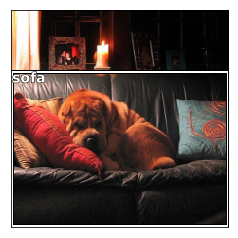

In [85]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][1]])

### Add a custom head to the end of resnet34

We need one output activation for each class (for its probability) plus one for each bounding box coordinate. We'll use an extra linear layer this time, plus some dropout, to help us train a more flexible model.

In [88]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

#### Definte a Loss, L1 regularization, and Accuracy helper functions


#### Loss function
- **`bb_i = F.sigmoid(bb_i)*224`** - force the value between 0 and 1 (times 224). This is to force the data into a specific range of values
- Where to put **`batch_norm`** ? Recommended to put it after **relu**, so you keep the ability to make negative numbers. 
- **`L1 loss + Cross Entropy Loss`** = `F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20`. The `x20` is approximated to ensure that the two losses are on the same scale

In [89]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

#### With the metrics defined, we find the learning rate

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 97%|█████████▋| 31/32 [00:09<00:00,  3.19it/s, loss=524]


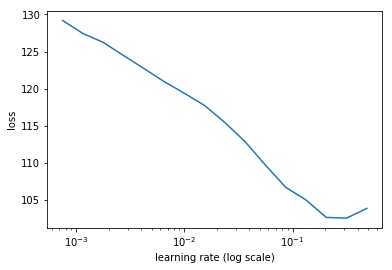

In [90]:
learn.lr_find()
learn.sched.plot()

#### Set the rate

In [91]:
lr=1e-2

#### Fit the Model

In [92]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      73.80378   43.574409  0.813852   31.699385 
    1      51.747788  37.229919  0.819561   25.624957     
    2      41.568981  35.318695  0.82497    24.513911     



[35.318695, 0.8249699547886848, 24.51391077041626]

#### Save our Model

In [93]:
learn.save('reg1_0')

#### Freeze everything except the last two layers

In [94]:
learn.freeze_to(-2)

In [ ]:
#### Setting learning rates

In [95]:
lrs = np.array([lr/100, lr/10, lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 29/32 [00:08<00:00,  3.36it/s, loss=230] 


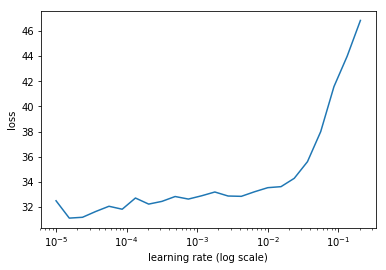

In [96]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [99]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      18.630316  36.514301  0.791466   21.233154 
    1      19.990961  33.011433  0.81881    20.244233     
    2      18.506014  31.954967  0.820763   19.621269     
    3      16.846955  31.920164  0.81881    19.204269     
    4      15.234001  31.665308  0.819261   18.943963     



[31.665308, 0.8192608207464218, 18.943962812423706]

In [100]:
learn.save('reg1_1')
learn.load('reg1_1')
learn.unfreeze()

In [101]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      13.102859  30.631477  0.817758   18.990284 
    1      13.380544  32.969467  0.810397   19.570258     
    2      13.436793  32.149635  0.821214   19.051544     
    3      12.934334  31.497986  0.83729    18.988035     
    4      12.444968  32.228378  0.819261   18.880555     
    5      11.878257  32.434448  0.809044   18.574428     
    6      11.490413  31.936653  0.822716   18.974106     
    7      10.877252  31.002441  0.832933   18.324932     
    8      10.552304  30.984261  0.832933   18.481523     
    9      10.308766  31.074959  0.81881    18.369649     



[31.074959, 0.8188100978732109, 18.369649052619934]

In [103]:
learn.save('reg1')
learn.load('reg1')

In [102]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

### Big Idea

Figuring out what hte main object in an image is, that is the difficult task. Finding the bounding box is the easier part. So a model that has two do both, the tasks inform each other since they share some concept together. As a result, they should share some of the layers of the network together.

In [104]:
from scipy.special import expit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


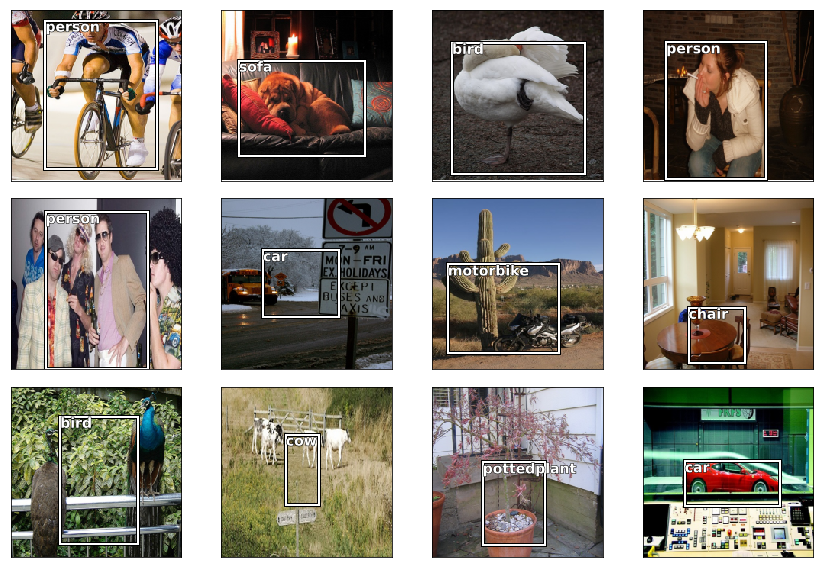

In [105]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()

### Checkout the Multi Label Classification 

The notebook is posted [link](https://github.com/fastai/fastai/blob/master/courses/dl2/pascal-multi.ipynb)